# Import Library

In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Average, Dropout, Dense, Concatenate, LSTM, Conv1D, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns
from keras.optimizers import Adam, RMSprop
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# Read Data

In [2]:
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'NASDAQ'
symbol = '^IXIC'

import yfinance as yf
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000


# EDA (Exploratory Data Analysis)

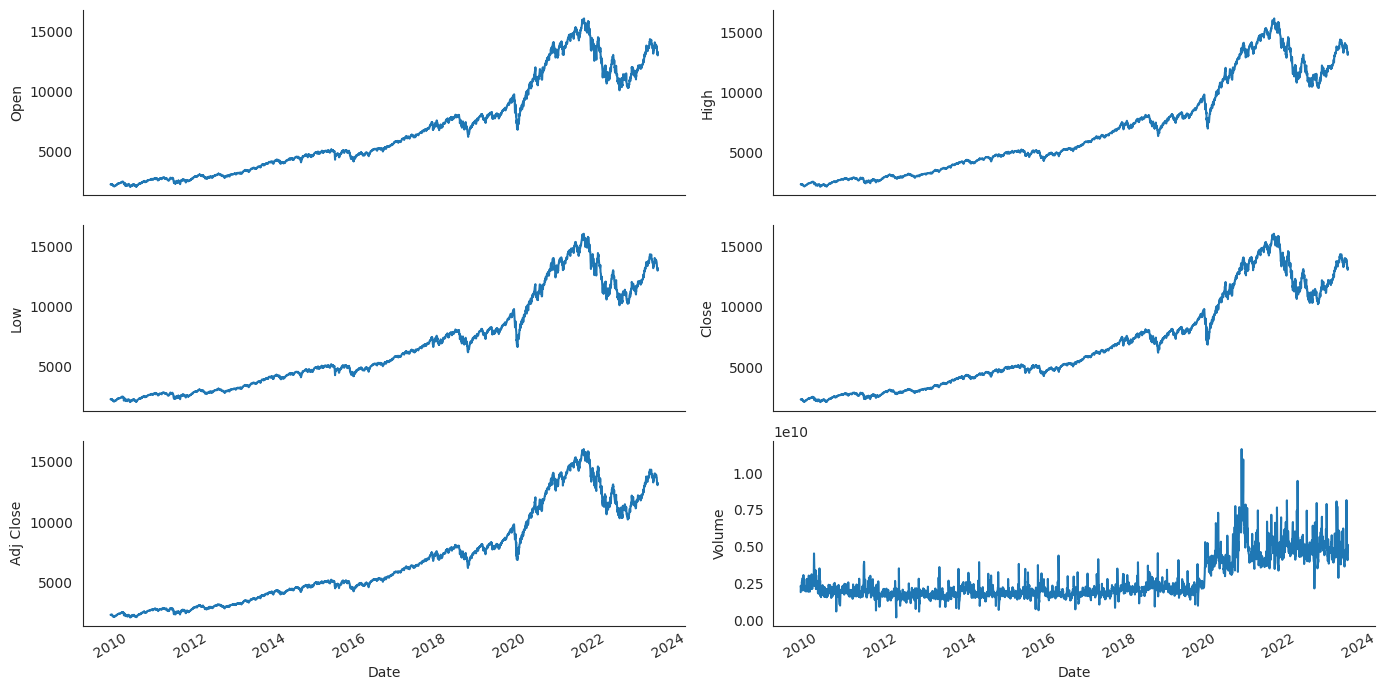

In [3]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000,3.459000e+03
mean,6814.703136,6860.046551,6764.755280,6815.637545,6815.637545,2.728868e+09
std,3881.799550,3912.749836,3846.543955,3881.159622,3881.159622,1.407283e+09
min,2099.659912,2110.659912,2061.139893,2091.790039,2091.790039,2.214300e+08
25%,3452.819946,3468.614990,3430.165039,3457.524902,3457.524902,1.804435e+09
50%,5313.490234,5325.879883,5284.839844,5309.830078,5309.830078,2.074120e+09
75%,9315.854980,9343.520020,9244.225098,9306.919922,9306.919922,3.639905e+09
max,16120.919922,16212.230469,16017.230469,16057.440430,16057.440430,1.162119e+10


**ค่าส่วนเสมอศูนย์ (variance)** เป็นค่าทางสถิติที่ใช้วัดระดับการกระจายหรือความแปรปรวนของข้อมูลในชุดข้อมูล. ค่าส่วนเสมอศูนย์บ่งบอกถึงความแตกต่างหรือการกระจายของข้อมูลจากค่าเฉลี่ยของข้อมูลนั้นๆ โดยค่าส่วนเสมอศูนย์จะเป็นค่าบวกและมีค่ามากขึ้นเมื่อข้อมูลกระจายห่างกันมากขึ้น และมีค่าน้อยลงเมื่อข้อมูลมีความเข้าใกล้ค่าเฉลี่ยกันมากขึ้น.

In [5]:
variance_close= np.var(df['Close'])
print(f"Variance of Close Price of Nasdaq Composite stock: {variance_close:.2f}")

Variance of Close Price of Nasdaq Composite stock: 15059045.17


## Histogram
เป็นกระบวนการทางสถิติที่ใช้ในการแสดงการกระจายของข้อมูล โดยการแบ่งช่วงของข้อมูลออกเป็นกลุ่มหรือช่วงเล็ก ๆ ที่เรียกว่า "บิน" (bin) และนับจำนวนข้อมูลที่ตกอยู่ในแต่ละบินนั้น ๆ จากนั้นแสดงบินแต่ละช่วงบนกราฟแท่ง ซึ่งจะช่วยในการสังเกตแนวโน้มและการกระจายของข้อมูลได้ง่ายขึ้น

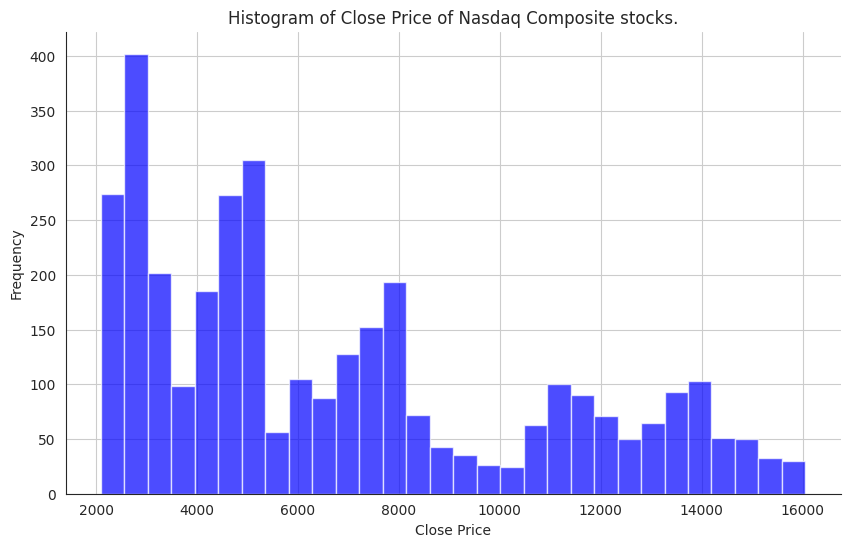

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['Close'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Histogram of Close Price of Nasdaq Composite stocks.')
plt.grid(True)
plt.show()

## Heatmap
เป็นกระบวนการทางสถิติที่ใช้สร้างกราฟที่มีลักษณะตารางสี่เหลี่ยมที่แสดงความสัมพันธ์ระหว่างข้อมูลแต่ละคู่ในรูปแบบของสี โดยค่าข้อมูลจะถูกแสดงในลักษณะของสีที่แสดงความค่อนข้างระหว่างข้อมูลแต่ละคู่ สีจะบ่งบอกความสัมพันธ์ของข้อมูลโดยใช้สเกลสีที่กำหนดไว้ ซึ่งมักจะใช้สีที่ต่างกันระหว่างค่าต่ำถึงค่าสูง หรือค่าน้อยถึงค่ามาก เพื่อช่วยในการแสดงข้อมูลแบบกราฟิกที่เข้าใจง่ายและรวมข้อมูลได้อย่างชัดเจน

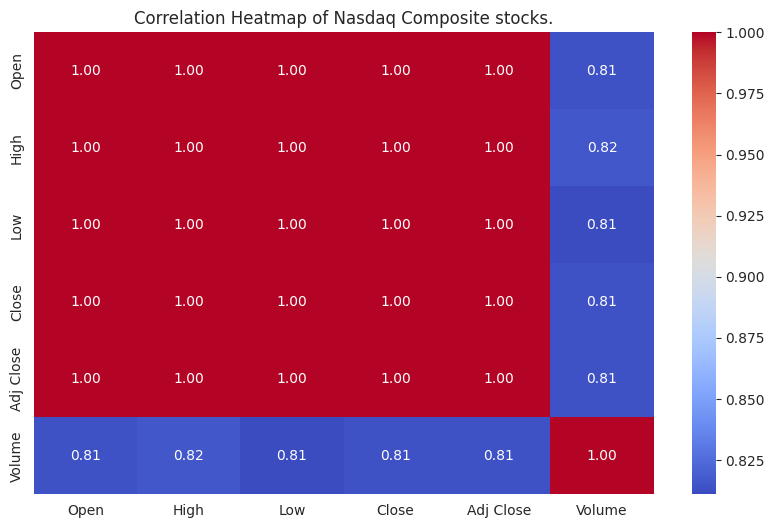

In [7]:
correlation_matrix_DOW = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_DOW, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Nasdaq Composite stocks.')
plt.show()

## Scatter plot (กราฟแบบกระจาย)
เป็นวิธีการแสดงข้อมูลแบบกราฟที่ใช้สองตัวแปร (variables) ในรูปแบบของจุด (points) บนแผนกราฟเพื่อศึกษาและแสดงความสัมพันธ์ระหว่างตัวแปรทั้งสอง โดยแต่ละจุดบน scatter plot จะแทนข้อมูลของคู่ตัวแปรที่ตรงกับตำแหน่งแกน x และแกน y ของจุดนั้น ๆ โดยค่า x จะแทนตัวแปรหนึ่งและค่า y จะแทนตัวแปรอีกหนึ่งตัวแปร ซึ่งสามารถใช้ในการสังเกตแนวโน้มและความสัมพันธ์ระหว่างตัวแปรได้อย่างชัดเจน

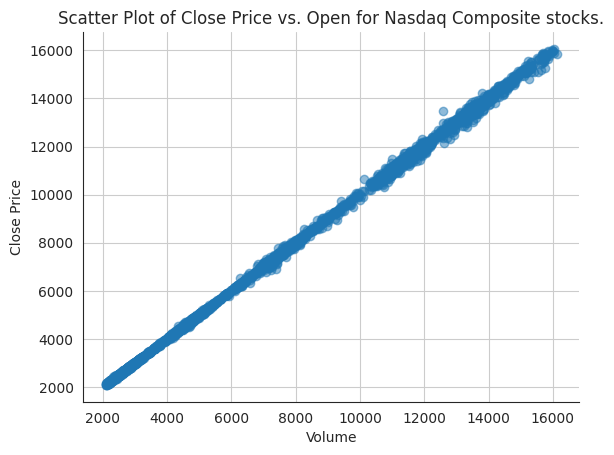

In [8]:
plt.scatter(df['Open'], df['Close'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.title('Scatter Plot of Close Price vs. Open for Nasdaq Composite stocks.')
plt.grid(True)
plt.show()

## "Resampling" or "Time Series Resampling"
เป็นการจับกลุ่มข้อมูลและการแบ่งช่วงเวลาของข้อมูลเวลา (time series data) ซึ่งเป็นกระบวนการที่ใช้ในการเปลี่ยนความถี่ของข้อมูลเวลา โดยรวมข้อมูลในช่วงเวลาที่กำหนดเพื่อให้เหมาะสมกับการวิเคราะห์หรือการสร้างกราฟในระบบข้อมูลที่มีความแตกต่างของความถี่ เช่น การจับกลุ่มข้อมูลรายวันเป็นข้อมูลรายสัปดาห์หรือรายเดือน.

In [9]:
weekly_close = df['Close'].resample('W').mean()
monthly_close = df['Close'].resample('M').mean()

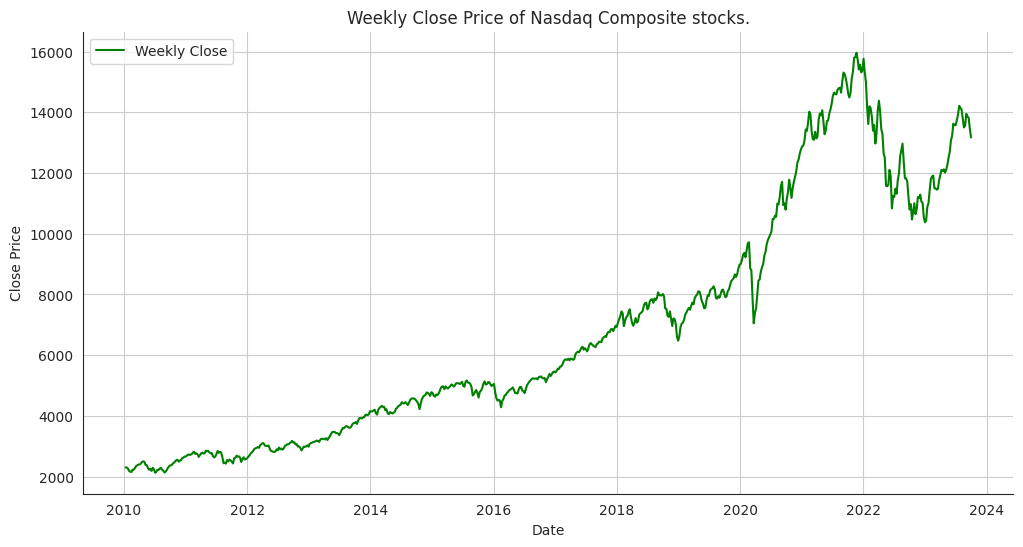

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_close.index, weekly_close, label='Weekly Close', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Weekly Close Price of Nasdaq Composite stocks.')
plt.legend()
plt.grid(True)
plt.show()

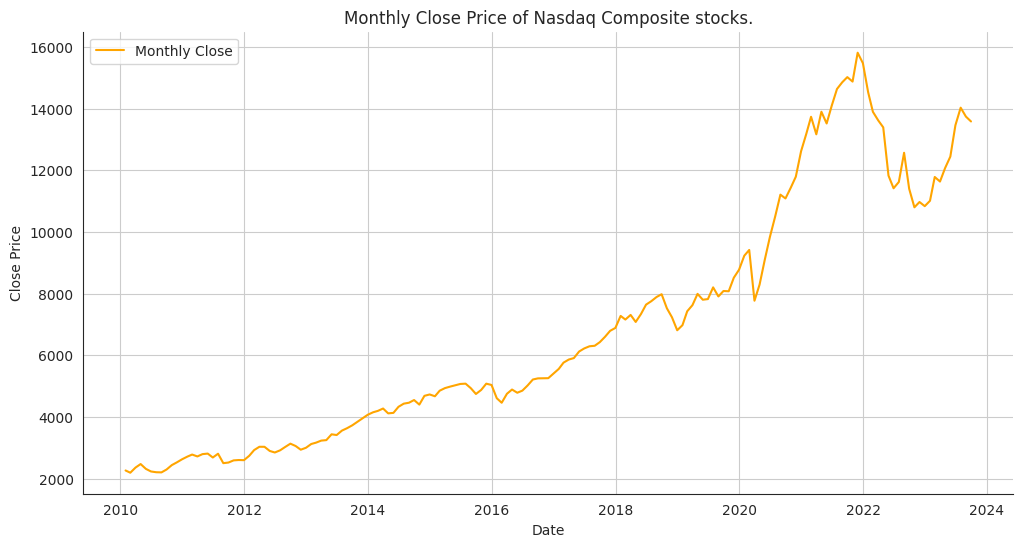

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_close.index, monthly_close, label='Monthly Close', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Monthly Close Price of Nasdaq Composite stocks.')
plt.legend()
plt.grid(True)
plt.show()

# Preprocessing data

In [12]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-09-25,13277.830078,13132.000000,13172.540039,13271.320312,4100290000,13271.320312
2023-09-26,13199.129883,13033.400391,13180.959961,13063.610352,4693540000,13063.610352
2023-09-27,13156.370117,12963.160156,13115.360352,13092.849609,4841410000,13092.849609
2023-09-28,13270.969727,13025.110352,13043.370117,13201.280273,4648390000,13201.280273
2023-09-29,13382.980469,13177.089844,13337.709961,13219.320312,5138500000,13219.320312


In [13]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3459, 5)


In [14]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

In [15]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

In [16]:
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [17]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of x_train: (2718, 50, 5)
Shape of y_train: (2718,)


# model selection
1. LSTM
2. RNN
3. GRU
4. Ensemble AVG(LSTM+GRU+RNN)

# 1. Long short-Term memory

In [18]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]

model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model._name = "LSTM"

# 2. Recurrent Neural Networks

In [19]:
n_neurons = x_train.shape[1] * x_train.shape[2]
n_neurons

250

In [20]:
model_RNN = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]

model_RNN.add(SimpleRNN(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_RNN.add(SimpleRNN(n_neurons, return_sequences=False))
model_RNN.add(Dense(5))
model_RNN.add(Dense(1))

optimizer = RMSprop(learning_rate=0.0005)
model_RNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model_RNN._name = "RNN"

# 3. Gated recurrent unit

In [21]:
model_GRU = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]

model_GRU.add(GRU(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_GRU.add(GRU(n_neurons, return_sequences=False))
model_GRU.add(Dense(5))
model_GRU.add(Dense(1))

optimizer = RMSprop(learning_rate=0.0005)
model_GRU.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model_GRU._name = "GRU"

In [22]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 250)           256000    
                                                                 
 lstm_1 (LSTM)               (None, 250)               501000    
                                                                 
 dense (Dense)               (None, 5)                 1255      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 758261 (2.89 MB)
Trainable params: 758261 (2.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model_RNN.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 250)           64000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 5)                 1255      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 190511 (744.18 KB)
Trainable params: 190511 (744.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 250)           192750    
                                                                 
 gru_1 (GRU)                 (None, 250)               376500    
                                                                 
 dense_4 (Dense)             (None, 5)                 1255      
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 570511 (2.18 MB)
Trainable params: 570511 (2.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
epochs = 50
early_stopping_patience = 10
batch_size = 32
model_checkpoint_file_lstm = 'LSTM_Model.h5'
model_checkpoint_file_rnn = 'RNN_Model.h5'
model_checkpoint_file_gru = 'GRU_Model.h5'
model_checkpoint_file_ensemble = 'Ensemble_Model_DOW.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, verbose=1, restore_best_weights=True)
model_checkpoint_lstm = ModelCheckpoint(model_checkpoint_file_lstm, monitor='val_loss', save_best_only=True, verbose=1)
model_checkpoint_rnn = ModelCheckpoint(model_checkpoint_file_rnn, monitor='val_loss', save_best_only=True, verbose=1)
model_checkpoint_gru = ModelCheckpoint(model_checkpoint_file_gru, monitor='val_loss', save_best_only=True, verbose=1)
model_checkpoint_ensemble = ModelCheckpoint(model_checkpoint_file_ensemble, monitor='val_loss', save_best_only=True, verbose=1)

In [26]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint_lstm]
                   )

Epoch 1/50
84/85 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0275
Epoch 1: val_loss improved from inf to 0.00238, saving model to LSTM_Model.h5
85/85 [==============================] - 13s 29ms/step - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0024 - val_mae: 0.0425
Epoch 2/50
15/85 [====>.........................] - ETA: 0s - loss: 7.5957e-04 - mae: 0.0183

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/85 [===========================>..] - ETA: 0s - loss: 5.4684e-04 - mae: 0.0165
Epoch 2: val_loss improved from 0.00238 to 0.00157, saving model to LSTM_Model.h5
85/85 [==============================] - 1s 10ms/step - loss: 5.4719e-04 - mae: 0.0166 - val_loss: 0.0016 - val_mae: 0.0341
Epoch 3/50
83/85 [============================>.] - ETA: 0s - loss: 3.8265e-04 - mae: 0.0146
Epoch 3: val_loss did not improve from 0.00157
85/85 [==============================] - 1s 9ms/step - loss: 4.2737e-04 - mae: 0.0151 - val_loss: 0.0051 - val_mae: 0.0660
Epoch 4/50
82/85 [===========================>..] - ETA: 0s - loss: 3.1860e-04 - mae: 0.0129
Epoch 4: val_loss did not improve from 0.00157
85/85 [==============================] - 1s 10ms/step - loss: 3.1992e-04 - mae: 0.0129 - val_loss: 0.0035 - val_mae: 0.0529
Epoch 5/50
82/85 [===========================>..] - ETA: 0s - loss: 2.7940e-04 - mae: 0.0121
Epoch 5: val_loss improved from 0.00157 to 0.00071, saving model to LSTM_Model.h5
85/85 [===

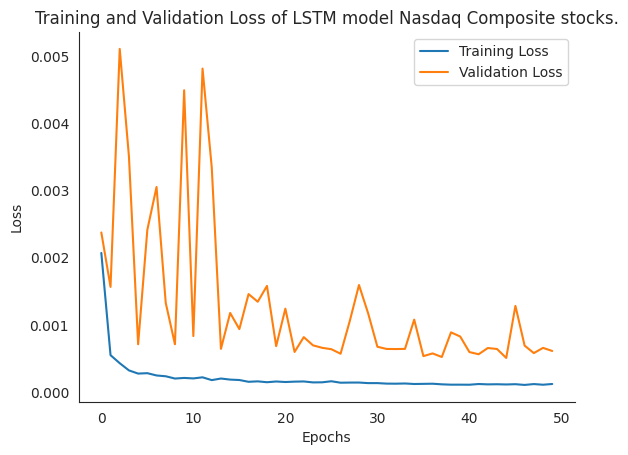

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of LSTM model Nasdaq Composite stocks.')
plt.legend()

plt.show()

In [28]:
history_RNN = model_RNN.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint_rnn]
                   )

Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 0.4343 - mae: 0.4471
Epoch 1: val_loss improved from inf to 0.56053, saving model to RNN_Model.h5
85/85 [==============================] - 10s 96ms/step - loss: 0.4343 - mae: 0.4471 - val_loss: 0.5605 - val_mae: 0.7462
Epoch 2/50
 1/85 [..............................] - ETA: 6s - loss: 0.0348 - mae: 0.1171

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - ETA: 0s - loss: 0.1422 - mae: 0.2731
Epoch 2: val_loss improved from 0.56053 to 0.06152, saving model to RNN_Model.h5
85/85 [==============================] - 7s 82ms/step - loss: 0.1422 - mae: 0.2731 - val_loss: 0.0615 - val_mae: 0.2386
Epoch 3/50
85/85 [==============================] - ETA: 0s - loss: 0.1405 - mae: 0.2506
Epoch 3: val_loss improved from 0.06152 to 0.00767, saving model to RNN_Model.h5
85/85 [==============================] - 7s 86ms/step - loss: 0.1405 - mae: 0.2506 - val_loss: 0.0077 - val_mae: 0.0761
Epoch 4/50
85/85 [==============================] - ETA: 0s - loss: 0.1059 - mae: 0.1842
Epoch 4: val_loss did not improve from 0.00767
85/85 [==============================] - 8s 93ms/step - loss: 0.1059 - mae: 0.1842 - val_loss: 0.5215 - val_mae: 0.7192
Epoch 5/50
85/85 [==============================] - ETA: 0s - loss: 0.3383 - mae: 0.4670
Epoch 5: val_loss improved from 0.00767 to 0.00601, saving model to RNN_Model.h5
85/85

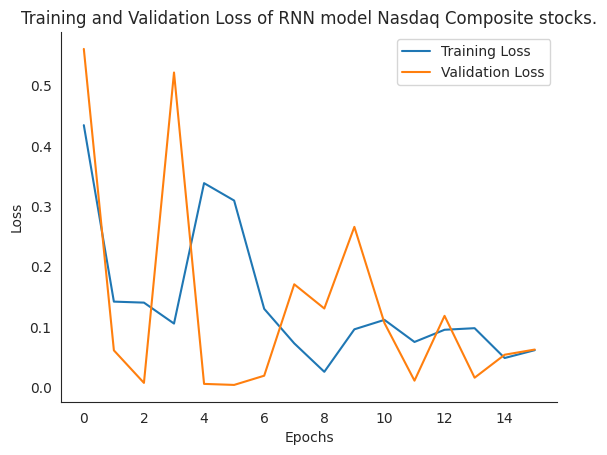

In [55]:
plt.plot(history_RNN.history['loss'], label='Training Loss')
plt.plot(history_RNN.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of RNN model Nasdaq Composite stocks.')
plt.legend()

plt.show()

In [30]:
history_GRU = model_GRU.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint_gru]
                   )

Epoch 1/50
82/85 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0265
Epoch 1: val_loss improved from inf to 0.00045, saving model to GRU_Model.h5
85/85 [==============================] - 5s 18ms/step - loss: 0.0019 - mae: 0.0258 - val_loss: 4.4800e-04 - val_mae: 0.0168
Epoch 2/50
21/85 [======>.......................] - ETA: 0s - loss: 7.5301e-04 - mae: 0.0182

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/85 [============================>.] - ETA: 0s - loss: 5.9631e-04 - mae: 0.0178
Epoch 2: val_loss did not improve from 0.00045
85/85 [==============================] - 1s 10ms/step - loss: 5.9877e-04 - mae: 0.0179 - val_loss: 0.0097 - val_mae: 0.0960
Epoch 3/50
84/85 [============================>.] - ETA: 0s - loss: 4.7879e-04 - mae: 0.0164
Epoch 3: val_loss did not improve from 0.00045
85/85 [==============================] - 1s 10ms/step - loss: 4.7752e-04 - mae: 0.0165 - val_loss: 7.3382e-04 - val_mae: 0.0211
Epoch 4/50
84/85 [============================>.] - ETA: 0s - loss: 3.5250e-04 - mae: 0.0143
Epoch 4: val_loss did not improve from 0.00045
85/85 [==============================] - 1s 12ms/step - loss: 3.4962e-04 - mae: 0.0142 - val_loss: 7.0941e-04 - val_mae: 0.0227
Epoch 5/50
79/85 [==========================>...] - ETA: 0s - loss: 3.3664e-04 - mae: 0.0140
Epoch 5: val_loss improved from 0.00045 to 0.00042, saving model to GRU_Model.h5
85/85 [==============================

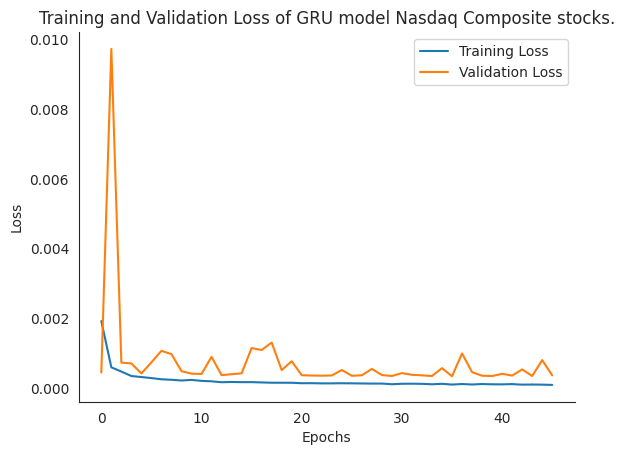

In [56]:
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of GRU model Nasdaq Composite stocks.')
plt.legend()

plt.show()

In [32]:
y_pred_scaled = model.predict(x_test)
y_pred_scaled_RNN = model_RNN.predict(x_test)
y_pred_scaled_GRU = model_GRU.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred_RNN = scaler_pred.inverse_transform(y_pred_scaled_GRU)
y_pred_GRU = scaler_pred.inverse_transform(y_pred_scaled_RNN)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

22/22 [==============================] - 1s 5ms/step


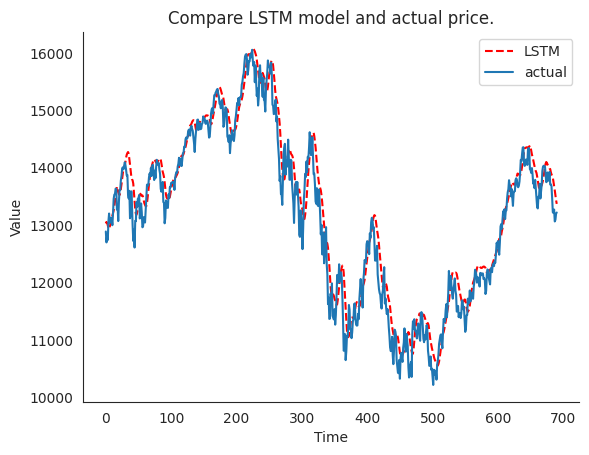

In [33]:
plt.plot(y_pred, label='LSTM',linestyle='--',color='red')
plt.plot(y_test_unscaled, label='actual')

plt.title("Compare LSTM model and actual price.")

plt.legend(['LSTM', 'actual'])

plt.xlabel('Time')
plt.ylabel('Value')

plt.show()

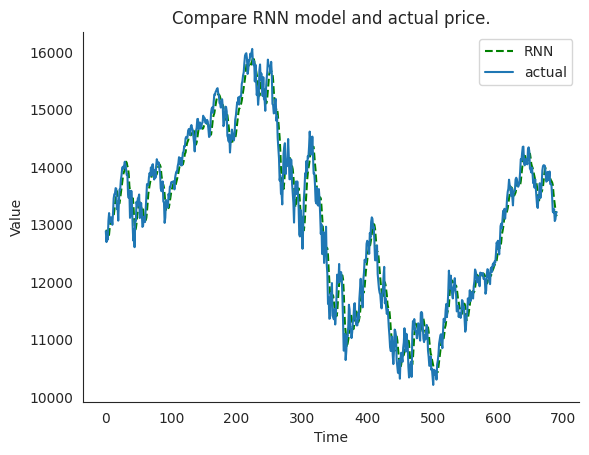

In [34]:
plt.plot(y_pred_RNN, label='RNN',linestyle='--',color='green')
plt.plot(y_test_unscaled, label='actual')

plt.title("Compare RNN model and actual price.")

plt.legend(['RNN', 'actual'])

plt.xlabel('Time')
plt.ylabel('Value')

plt.show()

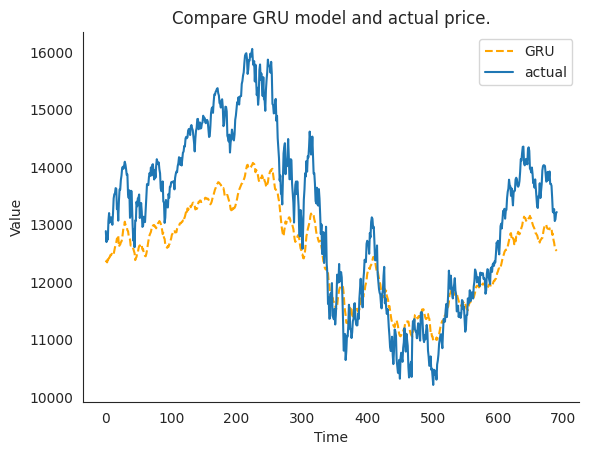

In [35]:
plt.plot(y_pred_GRU, label='GRU',linestyle='--',color='orange')
plt.plot(y_test_unscaled, label='actual')

plt.title("Compare GRU model and actual price.")

plt.legend(['GRU', 'actual'])

plt.xlabel('Time')
plt.ylabel('Value')

plt.show()

# 3. Ensemble model (LSTM+GRU+RNN)

In [36]:
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])


input_layer = Input(shape=((x_train.shape[1], x_train.shape[2])))

rnn_layer = SimpleRNN(128, activation='tanh')(input_layer)

lstm_layer = LSTM(128, activation='tanh')(input_layer)

gru_layer = GRU(128, activation='tanh')(input_layer)

average_layer = Average()([rnn_layer, lstm_layer, gru_layer])

dropout_layer = Dropout(0.2)(average_layer)

dense_layer1 = Dense(5, activation='relu')(dropout_layer)

dense_layer2 = Dense(1)(dense_layer1)

Ensemble_Model = Model(inputs=input_layer, outputs=dense_layer2)

optimizer = RMSprop(learning_rate=0.0005)
Ensemble_Model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

Ensemble_Model._name = "Ensemble"

Ensemble_Model.summary()

250 50 5
Model: "Ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 5)]              0         []                            
                                                                                                  
 simple_rnn_2 (SimpleRNN)    (None, 128)                  17152     ['input_1[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  68608     ['input_1[0][0]']             
                                                                                                  
 gru_2 (GRU)                 (None, 128)                  51840     ['input_1[0][0]']             
                                                                                  

In [37]:
history_ensemble = Ensemble_Model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint_ensemble]
                   )

Epoch 1/50
84/85 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0383
Epoch 1: val_loss improved from inf to 0.00995, saving model to Ensemble_Model_DOW.h5
85/85 [==============================] - 9s 49ms/step - loss: 0.0037 - mae: 0.0382 - val_loss: 0.0100 - val_mae: 0.0945
Epoch 2/50
 2/85 [..............................] - ETA: 5s - loss: 0.0014 - mae: 0.0288

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - ETA: 0s - loss: 9.7164e-04 - mae: 0.0213
Epoch 2: val_loss improved from 0.00995 to 0.00312, saving model to Ensemble_Model_DOW.h5
85/85 [==============================] - 4s 41ms/step - loss: 9.7164e-04 - mae: 0.0213 - val_loss: 0.0031 - val_mae: 0.0514
Epoch 3/50
85/85 [==============================] - ETA: 0s - loss: 6.8447e-04 - mae: 0.0180
Epoch 3: val_loss improved from 0.00312 to 0.00163, saving model to Ensemble_Model_DOW.h5
85/85 [==============================] - 3s 35ms/step - loss: 6.8447e-04 - mae: 0.0180 - val_loss: 0.0016 - val_mae: 0.0353
Epoch 4/50
85/85 [==============================] - ETA: 0s - loss: 4.9041e-04 - mae: 0.0154
Epoch 4: val_loss improved from 0.00163 to 0.00099, saving model to Ensemble_Model_DOW.h5
85/85 [==============================] - 3s 36ms/step - loss: 4.9041e-04 - mae: 0.0154 - val_loss: 9.8687e-04 - val_mae: 0.0267
Epoch 5/50
85/85 [==============================] - ETA: 0s - loss: 5.3138e-04 - mae: 

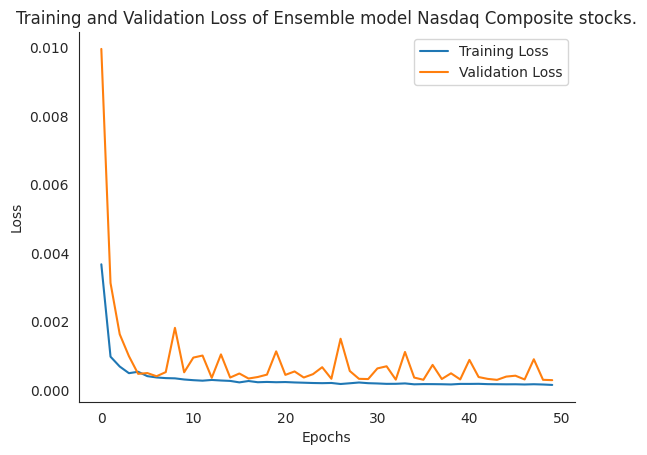

In [57]:
plt.plot(history_ensemble.history['loss'], label='Training Loss')
plt.plot(history_ensemble.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of Ensemble model Nasdaq Composite stocks.')
plt.legend()

plt.show()

In [39]:
y_pred_scaled_en = Ensemble_Model.predict(x_test)
# Unscale the predicted values
y_pred_en = scaler_pred.inverse_transform(y_pred_scaled_en)

22/22 [==============================] - 1s 7ms/step


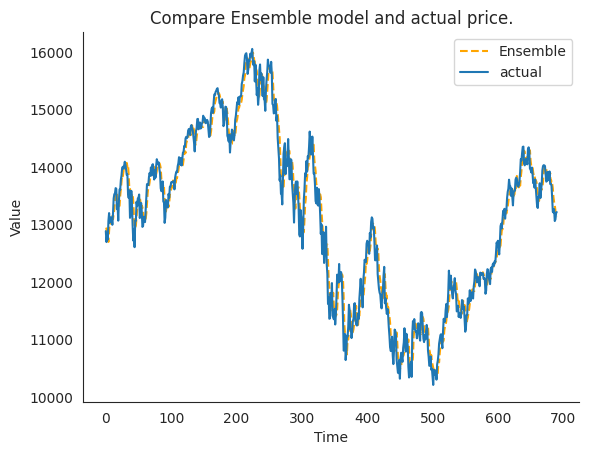

In [40]:
plt.plot(y_pred_en, label='Ensemble',linestyle='--',color='orange')
plt.plot(y_test_unscaled, label='actual')

plt.title("Compare Ensemble model and actual price.")

plt.legend(['Ensemble', 'actual'])

plt.xlabel('Time')
plt.ylabel('Value')

plt.show()

In [41]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE) of LSTM model: {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE) of LSTM model: {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE) of LSTM model: {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE) of LSTM model: 266.01
Mean Absolute Percentage Error (MAPE) of LSTM model: 2.09 %
Median Absolute Percentage Error (MDAPE) of LSTM model: 1.58 %


In [42]:
# Mean Absolute Error (MAE)
MAE_RNN = mean_absolute_error(y_test_unscaled, y_pred_RNN)
print(f'Median Absolute Error (MAE) of RNN model: {np.round(MAE_RNN, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE_RNN = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_RNN)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE) of RNN model: {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE_RNN = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_RNN)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE) of RNN model: {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE) of RNN model: 206.98
Mean Absolute Percentage Error (MAPE) of RNN model: 2.09 %
Median Absolute Percentage Error (MDAPE) of RNN model: 1.58 %


In [43]:
# Mean Absolute Error (MAE)
MAE_GRU = mean_absolute_error(y_test_unscaled, y_pred_GRU)
print(f'Median Absolute Error (MAE) of GRU model: {np.round(MAE_GRU, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE_GRU = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_GRU)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE) of GRU model: {np.round(MAPE_GRU, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE_GRU = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_GRU)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE) of GRU model: {np.round(MDAPE_GRU, 2)} %')

Median Absolute Error (MAE) of GRU model: 761.25
Mean Absolute Percentage Error (MAPE) of GRU model: 5.51 %
Median Absolute Percentage Error (MDAPE) of GRU model: 5.5 %


In [44]:
# Mean Absolute Error (MAE)
MAE_en = mean_absolute_error(y_test_unscaled, y_pred_en)
print(f'Median Absolute Error (MAE) of Ensemble model: {np.round(MAE_en, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE_en = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred_en)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE) of Ensemble model: {np.round(MAPE_en, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE_en = np.median((np.abs(np.subtract(y_test_unscaled, y_pred_en)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE) of Ensemble model: {np.round(MDAPE_en, 2)} %')

Median Absolute Error (MAE) of Ensemble model: 187.7
Mean Absolute Percentage Error (MAPE) of Ensemble model: 1.46 %
Median Absolute Percentage Error (MDAPE) of Ensemble model: 1.14 %


In [45]:
error_data = {
    'Model': ['RNN', 'LSTM','GRU', 'Ensemble'],
    'MAE': [MAE_RNN, MAE, MAE_GRU,MAE_en],
    'MAPE': [MAPE_RNN, MAPE, MAPE_GRU,MAPE_en],
    'MDAPE': [MDAPE_RNN, MDAPE,MDAPE_GRU ,MDAPE_en]
}
error_model = pd.DataFrame(error_data)

In [46]:
error_model

,Model,MAE,MAPE,MDAPE
0,RNN,206.975045,1.611073,1.292832
1,LSTM,266.005103,2.089483,1.579009
2,GRU,761.247371,5.506097,5.503628
3,Ensemble,187.702139,1.464065,1.141459


In [47]:
df_y_test_unscaled = pd.DataFrame(y_test_unscaled, columns=['y_test_unscaled'])
df_y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
df_y_pred_RNN = pd.DataFrame(y_pred_RNN, columns=['y_pred_RNN'])
df_y_pred_GRU = pd.DataFrame(y_pred_GRU, columns=['y_pred_GRU'])
df_y_pred_en = pd.DataFrame(y_pred_en, columns=['y_pred_en'])

In [48]:
price_compare = {
    'Close_Price': df_y_test_unscaled['y_test_unscaled'],
    'LSTM': df_y_pred['y_pred'],
    'RNN': df_y_pred_RNN['y_pred_RNN'],
    'GRU':df_y_pred_GRU['y_pred_GRU'],
    'Ensemble': df_y_pred_en['y_pred_en']
}

close_compare = pd.DataFrame(price_compare)

In [49]:
close_compare

,Close_Price,LSTM,RNN,GRU,Ensemble
0,12888.280273,13028.728516,12895.084961,12346.941406,12926.550781
1,12698.450195,13054.957031,12897.239258,12371.276367,12935.484375
2,12818.959961,13037.505859,12849.046875,12344.788086,12792.582031
3,12740.790039,12996.186523,12799.298828,12398.504883,12769.676758
4,13067.480469,12941.469727,12764.843750,12358.930664,12700.933594
...,...,...,...,...,...
686,13271.320312,13680.292969,13435.916016,12688.391602,13393.130859
687,13063.610352,13606.416016,13347.133789,12608.354492,13340.658203
688,13092.849609,13521.284180,13251.712891,12575.333008,13247.209961
689,13201.280273,13435.295898,13173.862305,12557.417969,13150.278320
